<a href="https://colab.research.google.com/github/sashalex007/deep_learning/blob/main/date_fruits_MLP_93percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
filepath = 'Documents/deep_learning/Date_Fruit_Datasets/Date_Fruit_Datasets.xlsx'
dataset = pd.read_excel(filepath, sheet_name=0)

targets_frame = dataset['Class'].to_frame() #isolate targets
targets_frame = pd.get_dummies(targets_frame, columns=['Class']) #one-hot encode targets
samples_frame = dataset.drop('Class', axis=1) #isolate samples

classes = list(targets_frame.columns) #save class names
classes = [c[6:] for c in classes]
samples_frame = (samples_frame - samples_frame.min()) / (samples_frame.max() - samples_frame.min()) #center data
samples_frame.shape, targets_frame.shape

((898, 34), (898, 7))

In [2]:
import torch
torch.manual_seed(3) #set RNG seed

samples_vals = samples_frame.values #dataframe to numpy tensor
targets_vals = targets_frame.values

samples = torch.tensor(samples_vals, dtype=torch.float) #numpy tensor to torch tensor
targets = torch.tensor(targets_vals, dtype=torch.float)

data = torch.cat([samples, targets], dim=1) #concat samples and targets
data = data[torch.randperm(data.size()[0])] #shuffle data

n = int(0.7*len(data)) #split into train/val
train_data = data[:n]
val_data = data[n:]
train_data.shape, val_data.shape

(torch.Size([628, 41]), torch.Size([270, 41]))

In [3]:
batch_size = 12 #set mini-batch size for stochastic optimization
fan_in = 34 #input size
expand = 2 #hidden layer size is (fan_in + expand). Dimensionality increase factor.
fan_out = 7 #output size (mulitnoulli distribution size after softmax)
eval_iters = 100 #evaluation interval

In [4]:
def get_batch(split): #get stochastic batch
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data), (batch_size,))
  x = torch.stack([data[i,:34] for i in ix]) #split samples and targets
  y = torch.cat([torch.nonzero(data[i,34:])[0] for i in ix])
  return x, y

@torch.no_grad()
def estimate_loss(): #evaluate model
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [5]:
import torch.nn as nn
from torch.nn import functional as F

class MLP(nn.Module): #model
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential( #mlp with batchnorm, tanh activation and dropout, and output layer
        nn.Linear(fan_in, fan_in + expand, bias=False),
        nn.LayerNorm(fan_in + expand),
        nn.Tanh(),
        nn.Dropout(0.35),
        nn.Linear(fan_in + expand, fan_out),
    )

  def forward(self, x, targets=None):
    logits = self.net(x)
    if targets is None:
      loss = None
    else:
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def predict(self, x, ground_truth):
    logits, loss = self(x)
    probs = F.softmax(logits, dim=1)
    prediction = torch.argmax(probs)
    return prediction, ground_truth


1555 model parameters
step 0: train loss 1.9532, val loss 1.9554
step 1000: train loss 0.5095, val loss 0.5681
step 2000: train loss 0.3510, val loss 0.4200
step 3000: train loss 0.2854, val loss 0.3784
step 4000: train loss 0.2494, val loss 0.2766
step 5000: train loss 0.2101, val loss 0.2778
step 6000: train loss 0.1873, val loss 0.2566
step 7000: train loss 0.2266, val loss 0.2578
step 8000: train loss 0.1493, val loss 0.2637
step 9000: train loss 0.1766, val loss 0.2288
step 10000: train loss 0.1317, val loss 0.2261
step 11000: train loss 0.1335, val loss 0.2324
step 12000: train loss 0.1232, val loss 0.2489
step 13000: train loss 0.1439, val loss 0.2029
step 14000: train loss 0.1286, val loss 0.2174
step 15000: train loss 0.1137, val loss 0.2381
step 16000: train loss 0.1194, val loss 0.2033
step 17000: train loss 0.1260, val loss 0.2021
step 18000: train loss 0.1218, val loss 0.2252
step 19000: train loss 0.1098, val loss 0.2192
step 19999: train loss 0.1276, val loss 0.2421
best

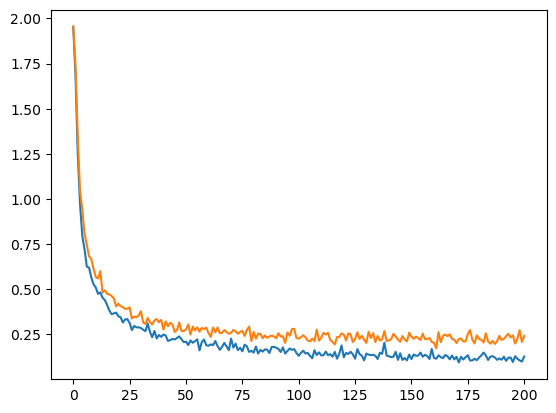

In [6]:
model = MLP()
print(sum(p.numel() for p in model.parameters()), 'model parameters')
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

min_val_loss = (float('inf'), -1)
model_state = None

max_iter = 20000
train_losses = []
val_losses = []

for iter in range(max_iter):

  if iter % 100 == 0 or iter == max_iter - 1: #evaluate model
    losses = estimate_loss()
    train_losses.append(losses['train'])
    val_losses.append(losses['val'])

    if losses['val'] < min_val_loss[0]: #save model state if val loss decreased
      min_val_loss = losses['val'], iter
      model_state = model.state_dict()

    if iter % 1000 == 0 or iter == max_iter - 1:
      print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

  xb, yb = get_batch('train')
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(f"best val loss {min_val_loss[0].item():.4f}, training iteration {min_val_loss[1]}")
import matplotlib.pyplot as plt
plt.plot(train_losses) #plot losses
plt.plot(val_losses)
plt.show()

accuracy : 92.9630
true: DOKOL prediction: DEGLET misclassified_count: 1
true: ROTANA prediction: DEGLET misclassified_count: 1
true: SOGAY prediction: DEGLET misclassified_count: 2
true: DEGLET prediction: DOKOL misclassified_count: 1
true: SAFAVI prediction: DOKOL misclassified_count: 1
true: BERHI prediction: IRAQI misclassified_count: 3
true: BERHI prediction: ROTANA misclassified_count: 1
true: IRAQI prediction: ROTANA misclassified_count: 1
true: DEGLET prediction: SAFAVI misclassified_count: 1
true: SOGAY prediction: SAFAVI misclassified_count: 1
true: DEGLET prediction: SOGAY misclassified_count: 4
true: DOKOL prediction: SOGAY misclassified_count: 1
true: ROTANA prediction: SOGAY misclassified_count: 1


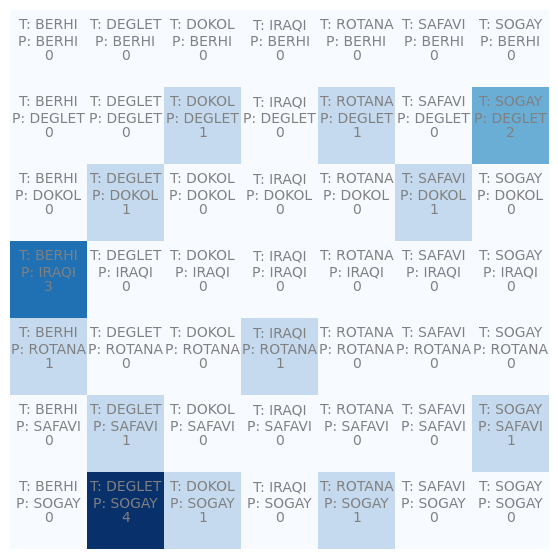

In [38]:
model = MLP()
model.load_state_dict(model_state) #load model with lowest val loss

model.eval()
with torch.no_grad(): #evaluate on entire valitation set
  incorrect = 0
  inc_data = {}
  for _class in classes: #initialize frequency map for all class pairs
    for __class in classes:
      if __class != _class:
        inc_data[(_class, __class)] = 0

  for i in range(len(val_data)):
    data = val_data
    ix = [i]
    x = torch.stack([data[i,:34] for i in ix])
    y = torch.cat([torch.nonzero(data[i,34:])[0] for i in ix])
    prediction, true_val = model.predict(x, y)
    if prediction.item() != true_val.item():
      inc_data[(classes[prediction.item()], classes[true_val.item()])] += 1
      incorrect += 1

print('accuracy :', f"{100-incorrect/len(val_data)*100:.4f}")
#collect misclassified
class_to_i = {c:i for i,c in enumerate(classes)}
N = torch.zeros((len(classes), len(classes)), dtype=torch.int32)
for (prediction, true), incorrect_count in inc_data.items():
  if incorrect_count > 0:
    N[class_to_i[prediction], class_to_i[true]] = incorrect_count
    print('true:', true, 'prediction:', prediction, 'misclassified_count:', incorrect_count)

#plot misclassified
plt.figure(figsize=(len(classes), len(classes)))
plt.imshow(N, cmap='Blues')
for i in range(len(classes)):
    for j in range(len(classes)):
        chstr = 'T: ' + classes[j] + '\nP: ' +  classes[i]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');
